List of tables


In [1]:
import pandas as pd
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

# Load all CSVs

This is where CSVs are loaded

In [2]:
test = pd.read_csv("Test Set.csv")

In [3]:
threshold_of_risk = { # MACE, Mortality. All numbers derrived from VAL
    'Top 7% of Risk':[0.8012191462516784,0.5127009725570678],
    'Top 15% of Risk':[0.6455605030059813,0.3352705240249634],
    'Top 50% of Risk':[0.327571839094162,0.07675295323133469],
    "Max Youden's index":[0.32820358872413635,0.2416664808988571]
}



# Specify Thresholds for mortality and mace and RCRI

In [4]:
pre_opnet_thresh_mort = threshold_of_risk['Top 7% of Risk'][1]
pre_opnet_thresh_mace = threshold_of_risk['Top 7% of Risk'][0]
rcri_thresh = 2

In [5]:
def auprc(y,x):
    prcs = []
    for i in tqdm(range(0,1000)):
        choice = np.random.choice(a=[False, True], size=len(y))
        prcs.append(average_precision_score(y[choice], x[choice]))
        precision, recall, thresholds = precision_recall_curve(y[choice], x[choice])
        plt.plot( recall,precision,color='orange',alpha = 0.1)
        plt.xlabel("Precision")
        plt.ylabel("Recall")
    precision, recall, thresholds = precision_recall_curve(y, x)
    return str(round(np.nanmean(prcs),2))+' ( '+str(round(np.nanpercentile(prcs,2.5),2))+' - '+str(round(np.nanpercentile(prcs,97.5),2))+' )' 

In [6]:
# Function for calculating specificty, sensitivity, odds ratio, f1, PPV, NPV, and auc bootstrap
def bootstrap(x,y,thresh):
    spec = []
    sens = []
    f1 = []
    oddr = []
    PPV = []
    NPV = []
    aucs = []

    for i in range(2000):
        choice = np.random.choice(a=[False, True], size=len(x))
        fpr,tpr, _ = roc_curve(x[choice],y[choice])
        
        aucs.append(auc(fpr,tpr)) # AUC
        
        tn, fp, fn, tp = confusion_matrix(x[choice],1*(y>thresh)[choice]).ravel()
        
        specificity = tn / (tn+fp) # Formula for specificity
        sensitivity = tp / (tp+fn) # Formula for Sensitivity
        
        spec.append(specificity)
        sens.append(sensitivity)
        
        oddr.append((tn*tp)/(fp*fn)) # Odds Ratio
        
        f1.append(f1_score(x[choice],1*(y>thresh)[choice])) # F1 Calculation
        
        PPV.append(tp/(tp+fp)) # PPV
        
        NPV.append(tn/(tn+fn)) # NPV
        
    return sens,spec,f1,oddr,PPV,NPV,aucs

In [7]:
# Convert to Text with confidence interval
def textify(x):
    return str(round(np.nanmean(x),2))+' ( '+str(round(np.nanpercentile(x,2.5),2))+' - '+str(round(np.nanpercentile(x,97.5),2))+' )' 

# Supplementary Table 1

Compare Thresholds

In [8]:
outcome = {
    'Mortality':'Mort',
    'MACE':'MACE'
}

outcome_df = []
thresh_df = []
Specificity_df = []
Sens_df = []
oddr_df = []
ppv_df = []
npv_df = []

for out in outcome.keys():
    for threshold in tqdm(threshold_of_risk.keys()):
        

        if out == 'Mort':
            thresh = threshold_of_risk[threshold][1]
        else:
            thresh = threshold_of_risk[threshold][0]
        x,y = test[outcome[out]],test[outcome[out]+'_pred']
        sens,spec,f1,oddr,PPV,NPV,aucs = bootstrap(x,y,thresh)
        
        outcome_df.append(out)
        thresh_df.append(threshold)
        Specificity_df.append(textify(spec))
        Sens_df.append(textify(sens))
        oddr_df.append(textify(oddr))
        ppv_df.append(textify(PPV))
        npv_df.append(textify(NPV))
suptable1 = pd.DataFrame({"Outcome":outcome_df,"Threshold of Risk":thresh_df,
                      'Specificty':Specificity_df,'Sensitivity':Sens_df,
                      'Odds Ratio For Event':oddr_df,'PPV':ppv_df,
                      'NPV':npv_df}
                     )
suptable1.groupby(['Outcome','Threshold of Risk']).first()

100%|██████████| 4/4 [00:36<00:00,  9.24s/it]


Specificty           Sensitivity  \
Outcome   Threshold of Risk                                                
MACE      Max Youden's index  0.54 ( 0.52 - 0.55 )  0.81 ( 0.75 - 0.88 )   
          Top 15% of Risk     0.88 ( 0.88 - 0.89 )  0.41 ( 0.32 - 0.49 )   
          Top 50% of Risk     0.54 ( 0.52 - 0.55 )  0.81 ( 0.75 - 0.88 )   
          Top 7% of Risk      0.95 ( 0.94 - 0.95 )  0.25 ( 0.18 - 0.32 )   
Mortality Max Youden's index  0.87 ( 0.86 - 0.88 )  0.57 ( 0.47 - 0.67 )   
          Top 15% of Risk     0.97 ( 0.97 - 0.98 )   0.31 ( 0.21 - 0.4 )   
          Top 50% of Risk     0.87 ( 0.86 - 0.87 )  0.57 ( 0.47 - 0.67 )   
          Top 7% of Risk       0.99 ( 0.99 - 1.0 )  0.07 ( 0.02 - 0.12 )   

                                 Odds Ratio For Event                   PPV  \
Outcome   Threshold of Risk                                                   
MACE      Max Youden's index     5.32 ( 3.48 - 8.44 )  0.04 ( 0.03 - 0.05 )   
          Top 15% of Risk        5.34 ( 3.68 - 7.37 )   0.08 ( 0.06 - 0.1 )   
          Top 50% of Risk        5.27 ( 3.44 - 8.28 )  0.04 ( 0.03 - 0.05 )   
          Top 7% of Risk         6.24 ( 3.99 - 9.03 )  0.11 ( 0.07 - 0.14 )   
Mortality Max Youden's index    8.87 ( 5.81 - 13.63 )  0.06 ( 0.05 - 0.08 )   
          Top 15% of Risk     17.48 ( 10.02 - 27.25 )   0.16 ( 0.1 - 0.21 )   
          Top 50% of Risk       8.84 ( 5.64 - 13.27 )  0.06 ( 0.05 - 0.08 )   
          Top 7% of Risk       14.36 ( 3.51 - 30.08 )  0.17 ( 0.05 - 0.29 )   

                                               NPV  
Outcome   Threshold of Risk                         
MACE      Max Youden's index  0.99 ( 0.99 - 0.99 )  
          Top 15% of Risk     0.98 ( 0.98 - 0.99 )  
          Top 50% of Risk     0.99 ( 0.99 - 0.99 )  
          Top 7% of Risk      0.98 ( 0.98 - 0.98 )  
Mortality Max Youden's index  0.99 ( 0.99 - 0.99 )  
          Top 15% of Risk     0.99 ( 0.99 - 0.99 )  
          Top 50% of Risk     0.99 ( 0.99 - 0.99 )  
          Top 7% of Risk      0.99 ( 0.98 - 0.99 )

# Table 2

Compare different sets (interal vs external)

In [10]:
model_outcome = [
    'Mortality | PreOpNet (CSMC)',
    'Mortality | RCRI',
    'MACE | PreOpNet (CSMC)',
    'MACE | RCRI'
]

outcome_df = []
model_df = []
auc_df = []
Specificity_df = []
Sens_df = []
oddr_df = []
ppv_df = []
npv_df = []


for mod_out in tqdm(model_outcome):
    out, model = mod_out.split('|')
    if 'RCRI' in model:
        thresh = rcri_thresh
        if 'Mortality' in out:
            x,y = 1*test['Mort'],test['RCRI_Score']
        if 'MACE' in out:
            x,y = test['MACE'],test['RCRI_Score']
    else:
        if 'Mortality' in out:
            thresh = pre_opnet_thresh_mort
            if 'CSMC' in model:
                x,y = test['Mort'],test['Mort_pred']
                
        if 'MACE' in out:
            thresh = pre_opnet_thresh_mace
            if 'CSMC' in model:
                x,y = test['MACE'],1*test['MACE_pred']
        
    
    sens,spec,f1,oddr,PPV,NPV,aucs = bootstrap(x,y,thresh)
        
        
    outcome_df.append(out)
    model_df.append(model)
    auc_df.append(textify(aucs))
    Specificity_df.append(textify(spec))
    Sens_df.append(textify(sens))
    oddr_df.append(textify(oddr))
    ppv_df.append(textify(PPV))
    npv_df.append(textify(NPV))
table2 = pd.DataFrame({"Outcome":outcome_df,"Threshold of Risk":model_df,'AUC':auc_df,
                       'Odds Ratio For Event':oddr_df,
                      'Specificty':Specificity_df,'Sensitivity':Sens_df,
                      'PPV':ppv_df,'NPV':npv_df}
                     )
table2.groupby(['Outcome','Threshold of Risk']).first()

100%|██████████| 4/4 [00:35<00:00,  8.84s/it]


AUC   Odds Ratio For Event  \
Outcome    Threshold of Risk                                                
MACE        PreOpNet (CSMC)   0.77 ( 0.73 - 0.81 )   6.32 ( 3.83 - 9.13 )   
            RCRI              0.63 ( 0.59 - 0.68 )   1.68 ( 0.78 - 2.68 )   
Mortality   PreOpNet (CSMC)   0.83 ( 0.79 - 0.87 )  11.65 ( 7.07 - 17.8 )   
            RCRI              0.67 ( 0.61 - 0.72 )   2.06 ( 0.84 - 3.55 )   

                                        Specificty           Sensitivity  \
Outcome    Threshold of Risk                                               
MACE        PreOpNet (CSMC)   0.95 ( 0.94 - 0.95 )  0.25 ( 0.17 - 0.32 )   
            RCRI              0.94 ( 0.93 - 0.94 )   0.1 ( 0.05 - 0.15 )   
Mortality   PreOpNet (CSMC)   0.94 ( 0.94 - 0.95 )   0.41 ( 0.3 - 0.51 )   
            RCRI              0.94 ( 0.93 - 0.94 )  0.12 ( 0.06 - 0.19 )   

                                               PPV                   NPV  
Outcome    Threshold of Risk                                              
MACE        PreOpNet (CSMC)   0.11 ( 0.07 - 0.14 )  0.98 ( 0.98 - 0.98 )  
            RCRI              0.04 ( 0.02 - 0.06 )  0.98 ( 0.97 - 0.98 )  
Mortality   PreOpNet (CSMC)    0.1 ( 0.07 - 0.13 )  0.99 ( 0.99 - 0.99 )  
            RCRI              0.03 ( 0.01 - 0.04 )  0.99 ( 0.98 - 0.99 )

# Reclassification Results

Results of reclassifying RCRI based on preopnet MACE

In [11]:


preopnet_thresh = pre_opnet_thresh_mace

rcri_risk = []
pre_op_risk = []
count = []
percent_total = []
adverse = []
for i in ['Low','High']: # Above or Below RCRI Threshold
    for j in ['Low','High']: # Above or Below PreOpNet Threshold
        
        if i == 'Low':
            rcri_risk.append(i+" (Score  < "+str(rcri_thresh)+' )')
            temp = test[test.RCRI_Score<rcri_thresh]
        else:
            rcri_risk.append(i+" (Score  >= "+str(rcri_thresh)+' )')
            temp = test[test.RCRI_Score>=rcri_thresh]
        
        if j == 'Low':
            pre_op_risk.append(j+" (PreOpNet  < "+str(round(preopnet_thresh,2))+' )')
            temp = temp[temp.MACE_pred<preopnet_thresh]
        else:
            pre_op_risk.append(j+" (PreOpNet  >= "+str(round(preopnet_thresh,2))+' )')
            temp = temp[temp.MACE_pred>=preopnet_thresh]
            
        count.append(len(temp)) # How many total patients
        percent_total.append(round(100*len(temp)/len(temp),2)) # Percentage of total patients
        percent_adverse = str(round(100*sum(temp.MACE)/len(temp),2)) # MACE Percentage
        count_adverse = str(sum(temp.MACE)) # MACE Count
        adverse.append(count_adverse+' ( '+percent_adverse+'% ) ')

reclass = pd.DataFrame(
    {
        'RCRI Score':rcri_risk,'PreOpRisk Classification':pre_op_risk,
        'Number of Participants':count,'Percent of Participants':percent_total,
        'MACE':adverse
        
    }
)
reclass.groupby(['RCRI Score','PreOpRisk Classification']).first()

Number of Participants  \
RCRI Score          PreOpRisk Classification                           
High (Score  >= 2 ) High (PreOpNet  >= 0.8 )                     135   
                    Low (PreOpNet  < 0.8 )                      1055   
Low (Score  < 2 )   High (PreOpNet  >= 0.8 )                     194   
                    Low (PreOpNet  < 0.8 )                      4545   

                                              Percent of Participants  \
RCRI Score          PreOpRisk Classification                            
High (Score  >= 2 ) High (PreOpNet  >= 0.8 )                    100.0   
                    Low (PreOpNet  < 0.8 )                      100.0   
Low (Score  < 2 )   High (PreOpNet  >= 0.8 )                    100.0   
                    Low (PreOpNet  < 0.8 )                      100.0   

                                                          MACE  
RCRI Score          PreOpRisk Classification                    
High (Score  >= 2 ) High (PreOpNet  >= 0.8 )  18.0 ( 13.33% )   
                    Low (PreOpNet  < 0.8 )      39.0 ( 3.7% )   
Low (Score  < 2 )   High (PreOpNet  >= 0.8 )   17.0 ( 8.76% )   
                    Low (PreOpNet  < 0.8 )     66.0 ( 1.45% )

# Plot Production

Text(0.5, 1.0, 'PreOpNet AUC Curve for Mortality')

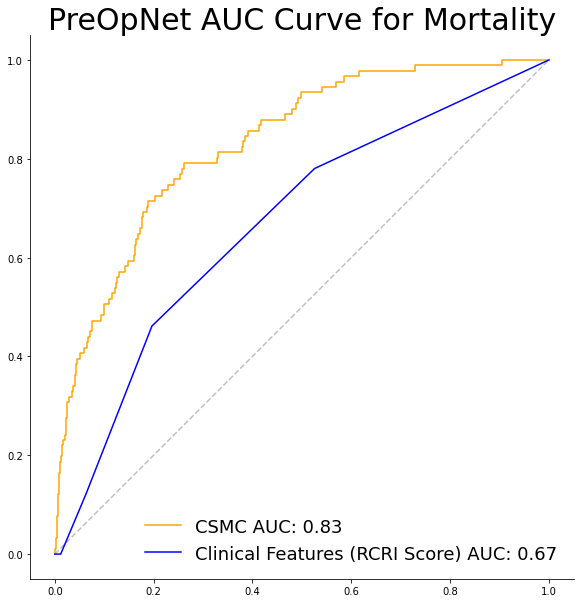

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(15,10))
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

csvs = {
    'CSMC':test,
    'Clinical Features (RCRI Score)':test,


}
colors = {
    'CSMC':'orange',
    'PreOpNet with Clinical Features':'red',
    'Clinical Features (RCRI Score)':'blue',
    'Columbia':'brown',
    'Stanford':'green'
}
ax.plot([0,1],[0,1],'--',color = 'gray',alpha = 0.5)
for i in csvs.keys():
    if not i == 'Clinical Features (RCRI Score)' and not i == 'CSMC':
        df = csvs[i]
        y_total,yhat_total = df['labels'],df['Prediction']
    elif i == 'Clinical Features (RCRI Score)':
        df = csvs[i]
        y_total,yhat_total = df['Mort'],df['RCRI_Score']
    elif i == 'CSMC':
        df = csvs[i]
        y_total,yhat_total = df['Mort'],df['Mort_pred']
    fpr,tpr, _ = roc_curve(y_total,yhat_total)
    ax.plot(fpr, tpr,
            label=i+' AUC: '+str(round(auc(fpr,tpr),2)),color = colors[i])
ax.set_aspect('equal', adjustable='box')
plt.legend(loc=4,framealpha=0,fontsize=18)
plt.title("PreOpNet AUC Curve for Mortality",fontsize=30)

Text(0.5, 1.0, 'PreOpNet PR Curve for Mortality')

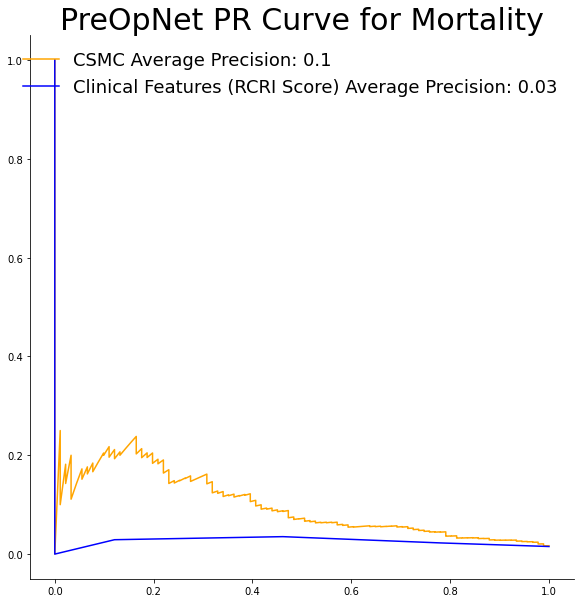

In [15]:
# mortality
#plt.style.use('seaborn')
plt.figure(figsize=(15,10))
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

csvs = {
    'CSMC':test,
    'Clinical Features (RCRI Score)':test

}
colors = {
    'CSMC':'orange',
    'PreOpNet with Clinical Features':'red',
    'Clinical Features (RCRI Score)':'blue',
    'Columbia':'brown',
    'Stanford':'green'
}
#ax.plot([0,1],[0,1],'--',color = 'gray',alpha = 0.5)
for i in csvs.keys():
    if not i == 'Clinical Features (RCRI Score)' and not i == 'CSMC':
        df = csvs[i]
        y_total,yhat_total = df['labels'],df['Prediction']
    elif i == 'Clinical Features (RCRI Score)':
        df = csvs[i]
        y_total,yhat_total = df['Mort'],df['RCRI_Score']
    elif i == 'CSMC':
        df = csvs[i]
        y_total,yhat_total = df['Mort'],df['Mort_pred']
    precision, recall, thresholds = precision_recall_curve(y_total, yhat_total)
    ax.plot(recall, precision,
            label=i+' Average Precision: '+str(round(average_precision_score(y_total,yhat_total),2)),color = colors[i])
ax.set_aspect('equal', adjustable='box')

plt.legend(loc=1,framealpha=0,fontsize=18)
plt.title("PreOpNet PR Curve for Mortality",fontsize=30)

Text(0.5, 1.0, 'AUC Curve for Adverse Cardiac Events')

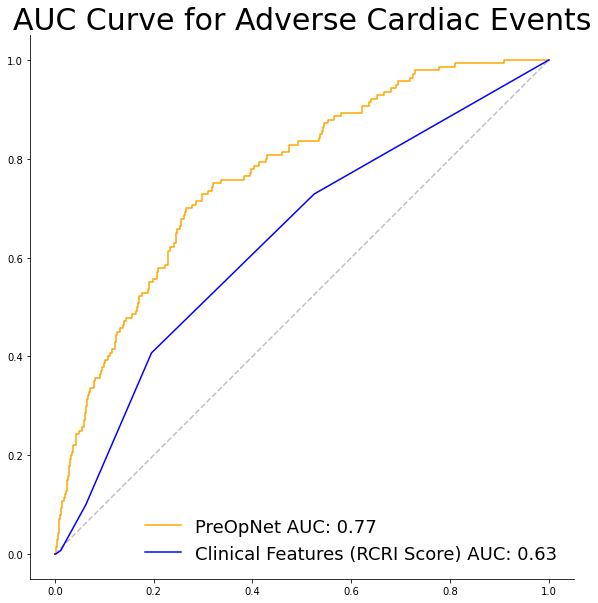

In [18]:
# RCRI_outcome
#plt.style.use('seaborn')
plt.figure(figsize=(15,10))
ax = plt.subplot(111)
csvs = {
    'PreOpNet':test,
    'Clinical Features (RCRI Score)':test

}
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
colors = {
    'PreOpNet':'orange',
    'Clinical Features (RCRI Score)':'blue',
}

ax.plot([0,1],[0,1],'--',color = 'gray',alpha = 0.5)
for i in csvs.keys():
    if not i == 'Clinical Features (RCRI Score)':
        y_total,yhat_total = test['MACE'],df['MACE_pred']
    else:
        y_total,yhat_total = test['MACE'],test['RCRI_Score']
    fpr,tpr, _ = roc_curve(y_total,yhat_total)
    ax.plot(fpr, tpr,
            label=i+' AUC: '+str(round(auc(fpr,tpr),2)),color = colors[i])
ax.set_aspect('equal', adjustable='box')
plt.legend(loc=4,framealpha=0,fontsize=18)
plt.title("AUC Curve for Adverse Cardiac Events",fontsize=30)